### Import Section

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);
from itertools import cycle

# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_columns', 200)
# pd.set_option('display.width', 20)
%matplotlib inline

### Train and Test Data Imports

In [364]:
# train
df = pd.read_csv('../datasets/train.csv')
df.shape

(2051, 81)

In [365]:
# test
kaggle_data = pd.read_csv('../datasets/test.csv')
kaggle_data.shape

(878, 80)

In [366]:
# First Submission little sample
submission = pd.DataFrame({'Id': kaggle_data['Id']})
submission['SalePrice'] = df['SalePrice'].mean()
submission.head()

,Id,SalePrice
0,2658,181469.701609
1,2718,181469.701609
2,2414,181469.701609
3,1989,181469.701609
4,625,181469.701609


In [367]:
submission.to_csv('../datasets/mean_sub.csv', index=False)

### First we clean the data and perform exploratory data analysis (EDA)

In [368]:
kaggle_data.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [369]:
df.isnull().sum().sort_values(ascending=False)

Pool QC         2042
Misc Feature    1986
Alley           1911
Fence           1651
Mas Vnr Type    1240
                ... 
Misc Val           0
Mo Sold            0
Yr Sold            0
Sale Type          0
SalePrice          0
Length: 81, dtype: int64

In [370]:
kaggle_data.isnull().sum().sort_values(ascending=False)

Pool QC           874
Misc Feature      837
Alley             820
Fence             706
Mas Vnr Type      535
                 ... 
Wood Deck SF        0
Open Porch SF       0
Enclosed Porch      0
3Ssn Porch          0
Screen Porch        0
Length: 80, dtype: int64

### Fill rows with median value in each respective column (these are ones with highest $\text{R}^2$ values).

In [371]:
columns_to_fillna = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Garage Yr Blt', 'TotRms AbvGrd', 'Mas Vnr Area']
df[columns_to_fillna] = df[columns_to_fillna].fillna(df[columns_to_fillna].median())
kaggle_data[columns_to_fillna] = kaggle_data[columns_to_fillna].fillna(kaggle_data[columns_to_fillna].median())

### Normalize null values of Lot Frontage in order to use them in the data analysis because this is an important numerical category. Do this for lone Basement finish SF 1 variable.

In [372]:
df['Lot Frontage'].fillna(df['Lot Frontage'].median(), inplace=True)

In [373]:
kaggle_data['Lot Frontage'].fillna(kaggle_data['Lot Frontage'].median(), inplace=True)

In [374]:
df['BsmtFin SF 1'].fillna(df['BsmtFin SF 1'].median(), inplace=True)

In [375]:
kaggle_data['BsmtFin SF 1'].fillna(kaggle_data['BsmtFin SF 1'].median(), inplace=True)

In [376]:
df['Bsmt Full Bath'].fillna(df['Bsmt Full Bath'].median(), inplace=True)

In [377]:
kaggle_data['Bsmt Full Bath'].fillna(kaggle_data['Bsmt Full Bath'].median(), inplace=True)

### Recheck null value counts.

In [378]:
df.isnull().sum().sort_values(ascending=False)

Pool QC         2042
Misc Feature    1986
Alley           1911
Fence           1651
Mas Vnr Type    1240
                ... 
Misc Val           0
Mo Sold            0
Yr Sold            0
Sale Type          0
SalePrice          0
Length: 81, dtype: int64

In [379]:
kaggle_data.isnull().sum().sort_values(ascending=False)

Pool QC           874
Misc Feature      837
Alley             820
Fence             706
Mas Vnr Type      535
                 ... 
Wood Deck SF        0
Open Porch SF       0
Enclosed Porch      0
3Ssn Porch          0
Screen Porch        0
Length: 80, dtype: int64

# Brainstorm factors to go by: 

## Ten in total ##

### Numerical:
Lot Area 
Lot frontage [yard]
Garage Area
Garage Cars

### Non-Numerical:

Sale Type 
Overall Qual
Overall Cond
Kitchen Qual 

### Relationship Variables

Time stamps:

Year Built and year remodeled Year Remod/Add - If these are spaced apart then we hypothesize value is up.
If one not the other, value down (i.e. built but never remodeled)


### Methodology: Start with heatmaps and histograms for numerical comparsion to get the right direction

#### Then work to Create Integer Encoding for The conditions of things
#### One-Hot Categorical Data Where you only want to keep the top category and leave that digit at the True (1) value

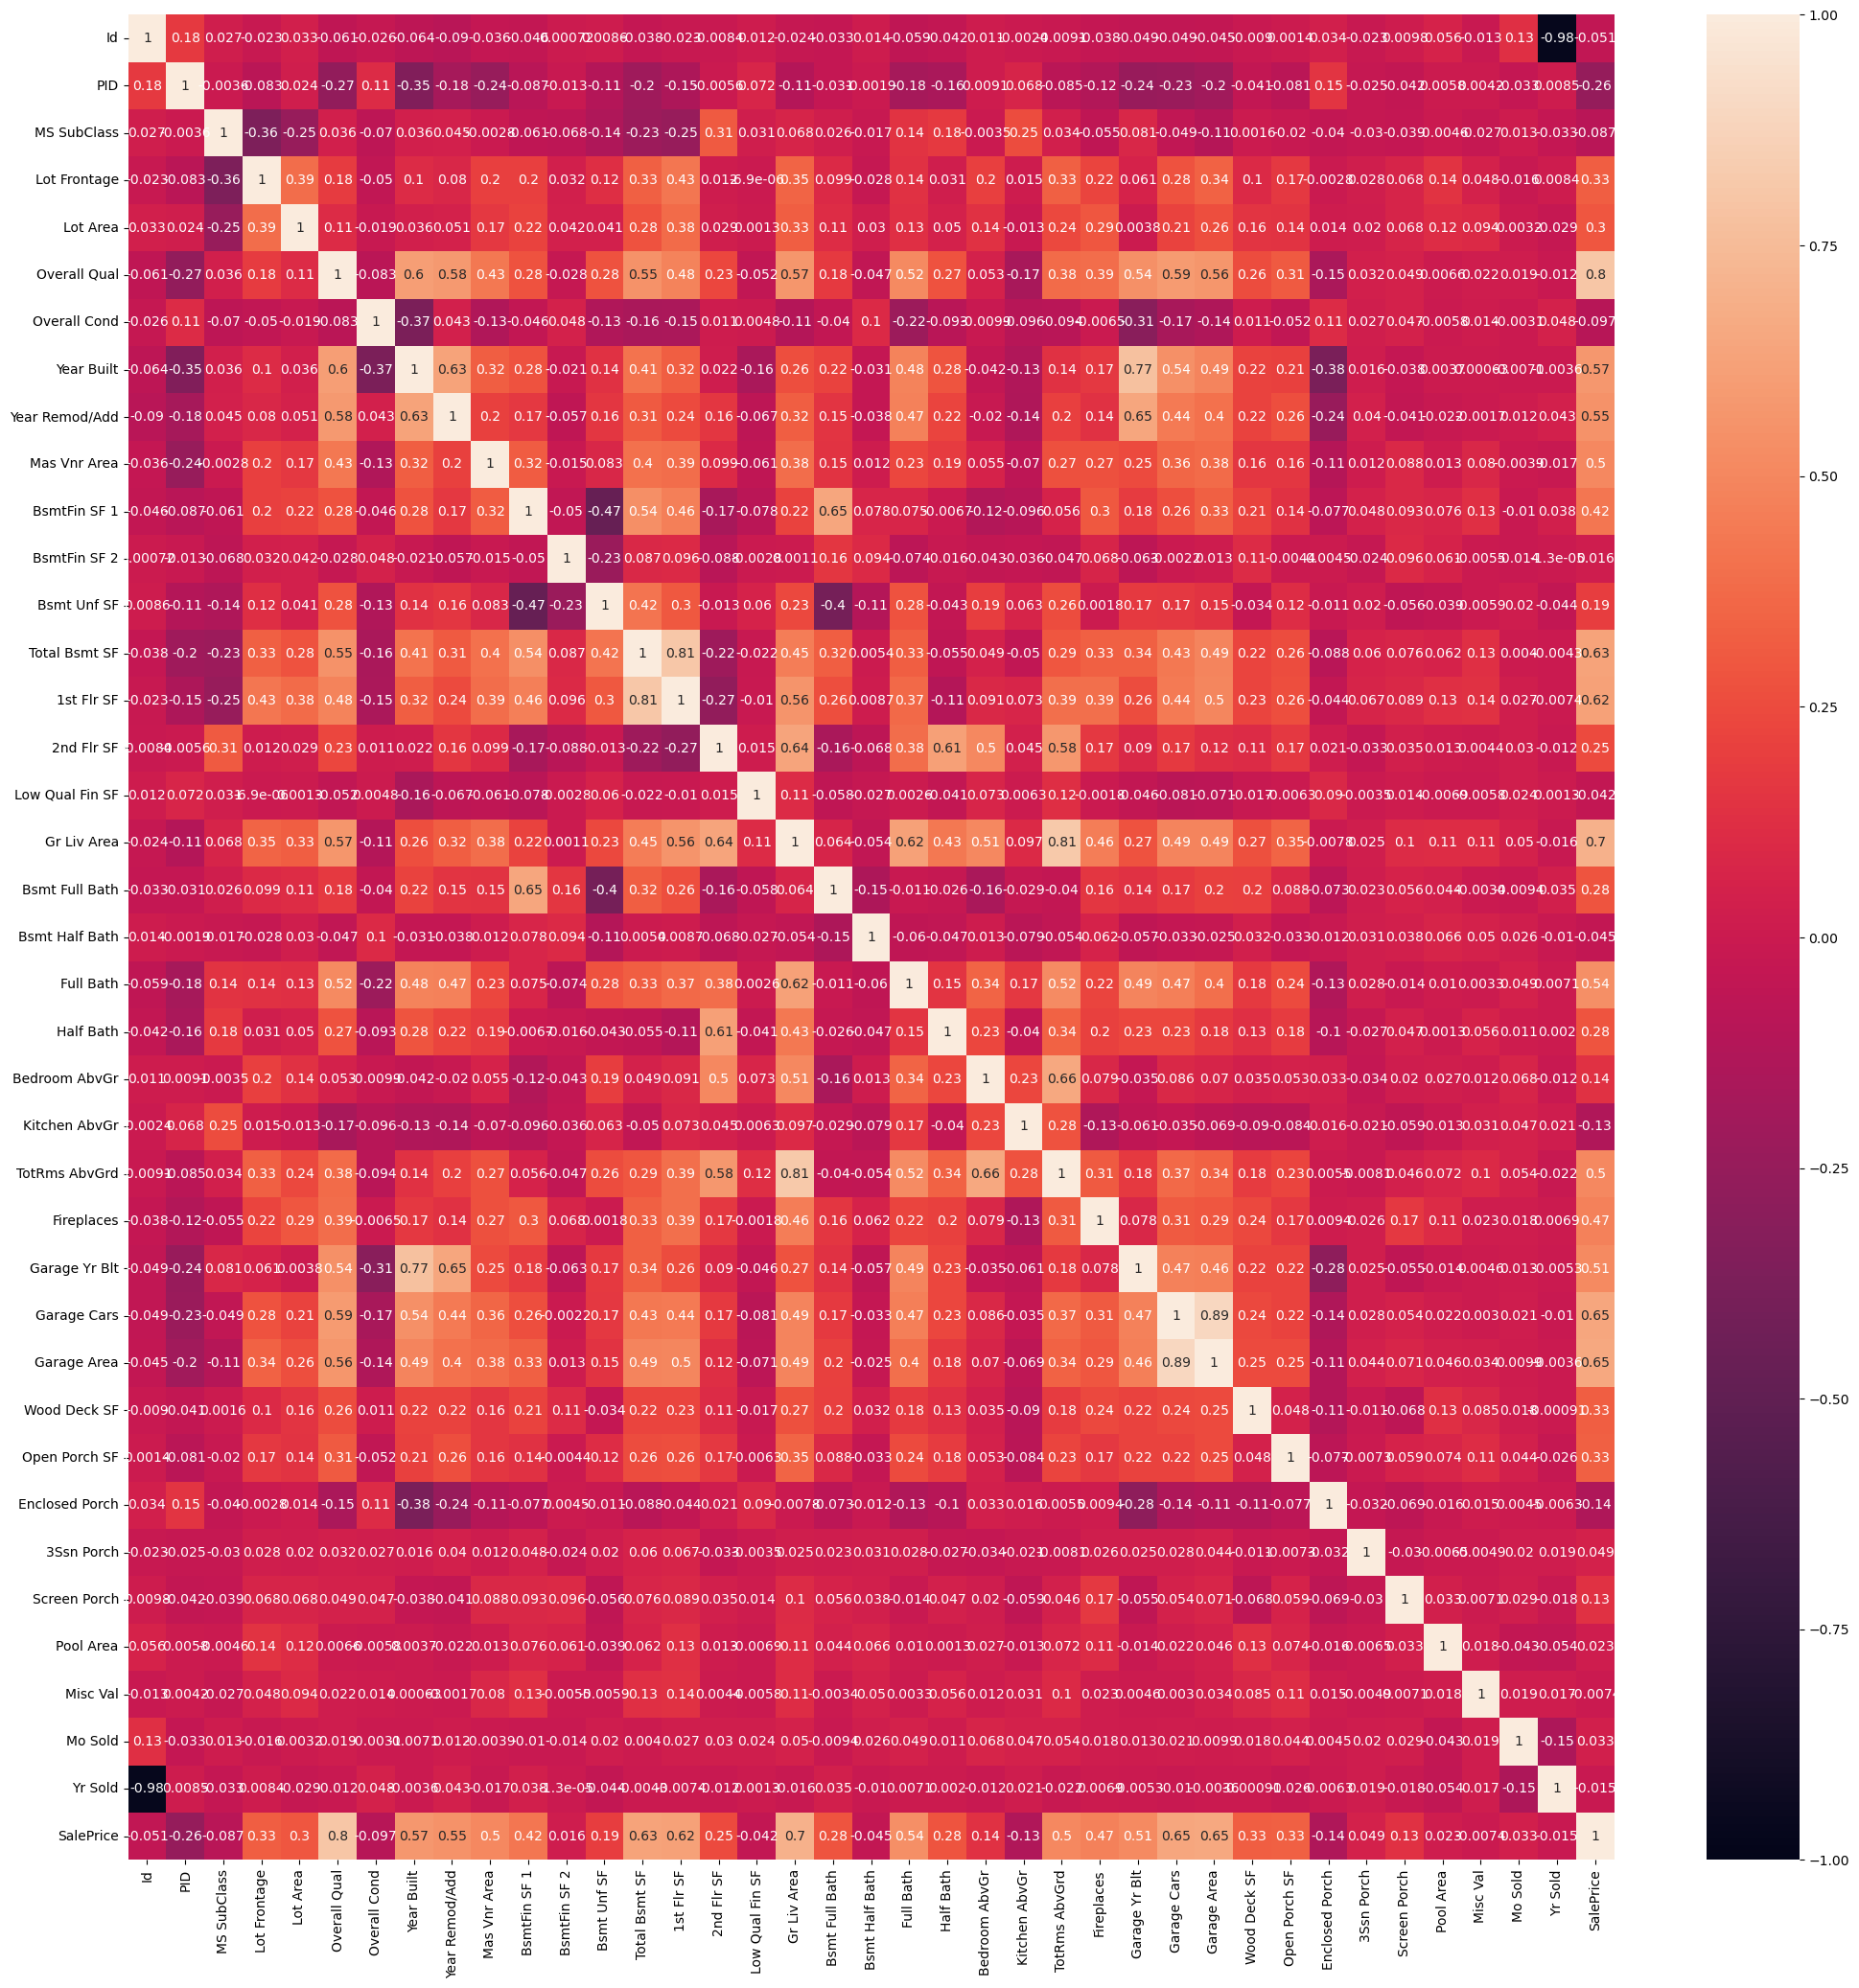

In [380]:
#Training Data Heat Map

#Make large enough to be legible
plt.figure(figsize = (25,25))

training_data_heatmap = sns.heatmap(df.corr(numeric_only=True), annot = True, vmin=-1, vmax=1);

plt.show()

plt.close()

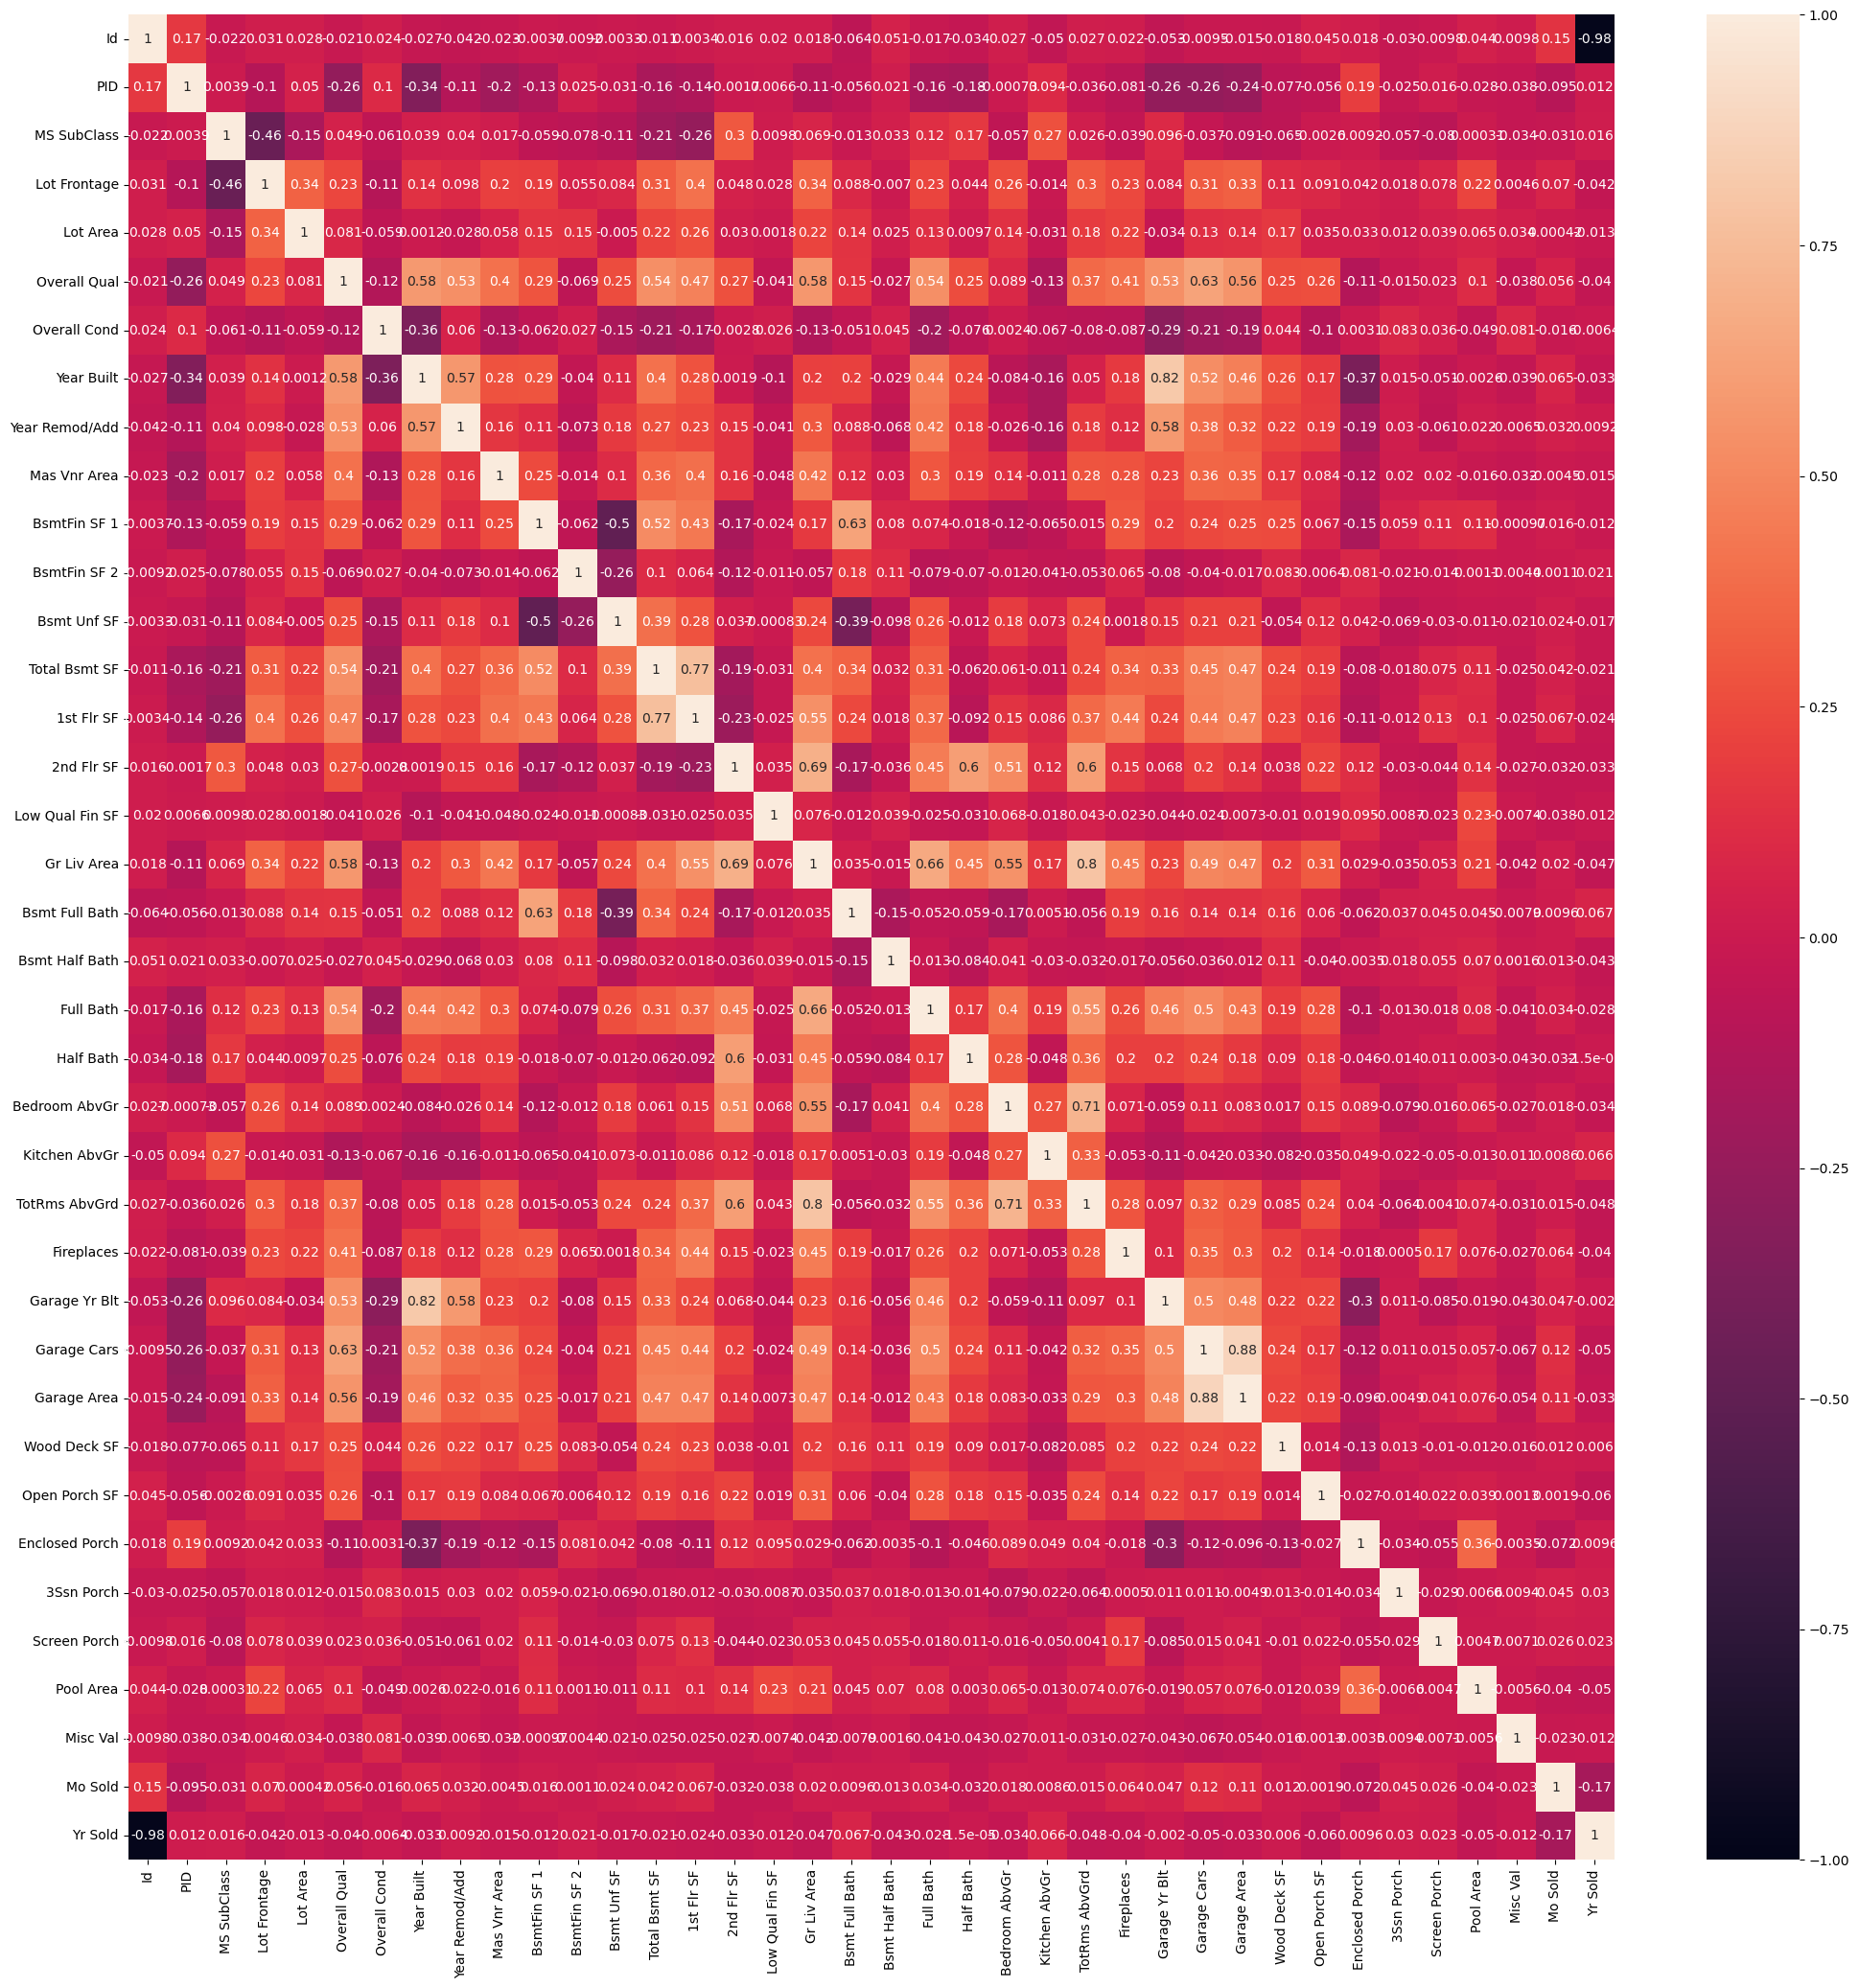

In [381]:
# Testing Data Heat Map

#Make large enough to be legible
plt.figure(figsize = (25,25))

testing_data_heatmap = sns.heatmap(kaggle_data.corr(numeric_only=True), annot = True, vmin=-1, vmax=1);

plt.show()

plt.close()

In [382]:
training_data_heatmap.figure.savefig('../images/training_data_heatmap.png', bbox_inches='tight', dpi=300)
testing_data_heatmap.figure.savefig('../images/testing_data_heatmap.png', bbox_inches='tight', dpi=300)

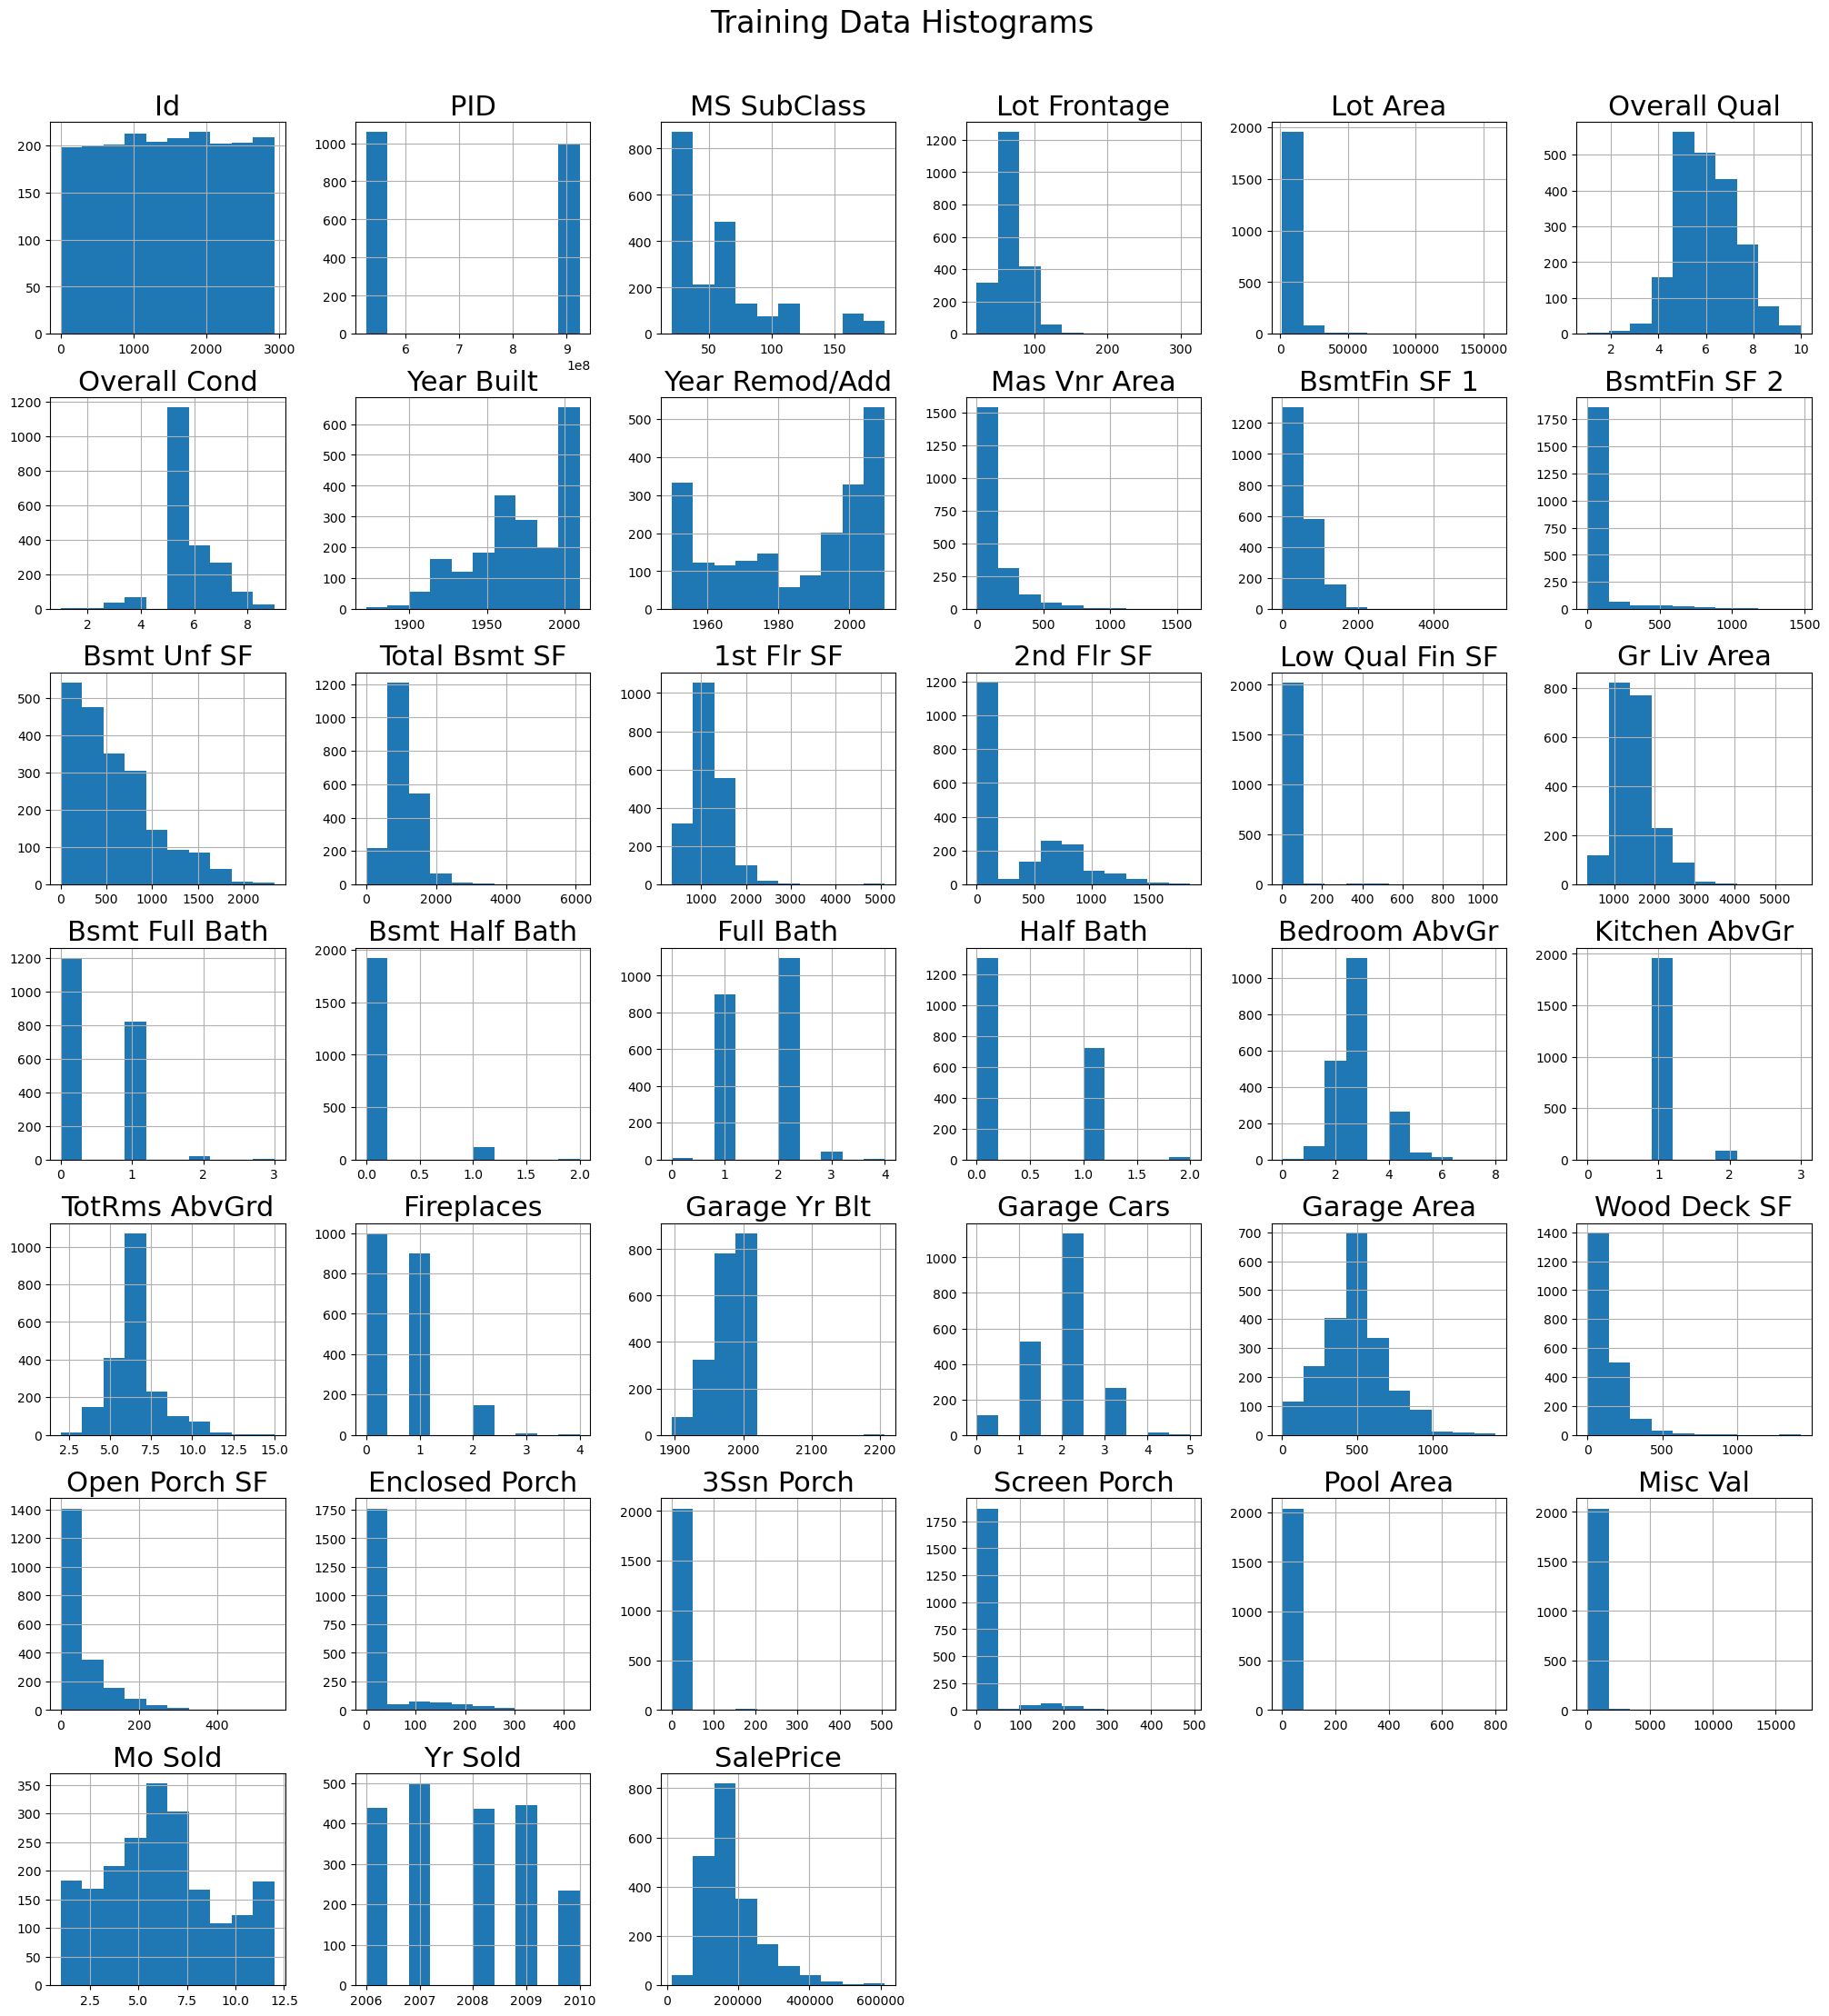

In [383]:
# Looking at histograms and prioritizing those variables with normal distributions
# Compare units on X axis with the dictionary units and the Y-Axis units are frequency (count)

df.hist(figsize=(25, 25))
plt.suptitle('Training Data Histograms', fontsize=24)
plt.subplots_adjust(top=0.93)  # You can adjust the 'top' parameter to change the space
plt.rc('axes', titlesize=22, labelsize=22)

plt.savefig('../images/Training_Data_Histograms.png', bbox_inches='tight', dpi=300)

plt.show()

plt.close()

In [384]:
df['After 2000'] = (df['Year Built'] >= 2000) | (df['Year Remod/Add'] >= 2000)
print(df['After 2000'].value_counts())

kaggle_data['After 2000'] = (df['Year Built'] >= 2000) | (df['Year Remod/Add'] >= 2000)
print(kaggle_data['After 2000'].value_counts())

After 2000
False    1289
True      762
Name: count, dtype: int64
After 2000
False    551
True     327
Name: count, dtype: int64


In [385]:
df['After 2000'].fillna(0, inplace=True)
# kaggle_data['After 2000'].fillna(kaggle_data['After 2000'].median(), inplace=True)

In [386]:
kaggle_data['After 2000'].fillna(0, inplace=True)
# kaggle_data['After 2000'].fillna(kaggle_data['After 2000'].median(), inplace=True)

In [387]:
numeric_columns = df.select_dtypes(include='number',exclude='category').columns

print(numeric_columns)

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')


In [388]:
# All Categorical Data

non_numeric_columns = df.select_dtypes(exclude='number').columns

print(non_numeric_columns)

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'After 2000'],
      dtype='object')


### Dummifying Relevant Variables

In [389]:
# Start with 'Heating' then do 'Heating QC','Central Air','Electrical','Kitchen Qual','Functional'

In [390]:
categorical_columns = ['Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional','Exterior 1st','Exterior 2nd','Neighborhood','Utilities']
dummy_columns = pd.get_dummies(df, columns=categorical_columns)

In [391]:
functional_columns = [col for col in dummy_columns.columns if 'Functional' in col]

# Display the 'Functional' related columns
print(dummy_columns[functional_columns])

      Functional_Maj1  Functional_Maj2  Functional_Min1  Functional_Min2  \
0               False            False            False            False   
1               False            False            False            False   
2               False            False            False            False   
3               False            False            False            False   
4               False            False            False            False   
...               ...              ...              ...              ...   
2046            False            False            False            False   
2047            False            False            False            False   
2048            False            False            False            False   
2049            False            False            False            False   
2050            False            False            False            False   

      Functional_Mod  Functional_Sal  Functional_Sev  Functional_Typ  
0              F

In [392]:
utility_columns = [col for col in dummy_columns.columns if 'Utilities' in col]
print(dummy_columns[utility_columns])

      Utilities_AllPub  Utilities_NoSeWa  Utilities_NoSewr
0                 True             False             False
1                 True             False             False
2                 True             False             False
3                 True             False             False
4                 True             False             False
...                ...               ...               ...
2046              True             False             False
2047              True             False             False
2048              True             False             False
2049              True             False             False
2050              True             False             False

[2051 rows x 3 columns]


In [393]:
df_combined = pd.concat([df, dummy_columns], axis=1)

In [394]:
df_combined

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr
0,109,533352170,60,RL,68.0,13517,Pave,NaN,IR1,Lvl,...,False,True,False,False,False,False,False,True,False,False
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,False,False,True,False,False,False,False,True,False,False
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,True,False,False
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,True,False,True,False,False
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,False,False,False,False,False,True,False,True,False,False
2047,785,905377130,30,RL,68.0,12342,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,True,False,False
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,False,False,False,False,False,False,False,True,False,False
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,True,False,False


In [395]:
# Kitchen Quality
df['Kitchen Qual_Ex'] = df_combined['Kitchen Qual_Ex']
df['Kitchen Qual_Fa'] = df_combined['Kitchen Qual_Fa']
df['Kitchen Qual_Gd'] = df_combined['Kitchen Qual_Gd']
df['Kitchen Qual_TA'] = df_combined['Kitchen Qual_TA']

In [396]:
# Heating Quality
df['Heating QC_Ex'] = df_combined['Heating QC_Ex']
df['Heating QC_Fa'] = df_combined['Heating QC_Fa']
df['Heating QC_Gd'] = df_combined['Heating QC_Gd']
df['Heating QC_TA'] = df_combined['Heating QC_TA']

In [397]:
df['Utilities_AllPub'] = df_combined['Utilities_AllPub']	
df['Utilities_NoSeWa'] = df_combined['Utilities_NoSeWa']
df['Utilities_NoSewr'] = df_combined['Utilities_NoSewr']

In [398]:
# Electrical Fuses - Do not Use
# df['Electrical_FuseA'] = df_combined['Electrical_FuseA']
# df['Electrical_FuseF'] = df_combined['Electrical_FuseF']
# df['Electrical_FuseP'] = df_combined['Electrical_FuseP']
# df['Electrical_SBrkr'] = df_combined['Electrical_SBrkr']

In [399]:
columns_to_add = ['Exterior 1st_AsbShng', 'Exterior 1st_AsphShn', 'Exterior 1st_BrkComm', 'Exterior 1st_BrkFace', 
                  'Exterior 1st_CBlock', 'Exterior 1st_CemntBd', 'Exterior 1st_HdBoard', 'Exterior 1st_ImStucc', 
                  'Exterior 1st_MetalSd', 'Exterior 1st_Plywood', 'Exterior 1st_Stone', 'Exterior 1st_Stucco', 
                  'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng', 'Exterior 1st_WdShing', 'Exterior 2nd_AsbShng', 
                  'Exterior 2nd_AsphShn', 'Exterior 2nd_Brk Cmn', 'Exterior 2nd_BrkFace', 'Exterior 2nd_CBlock', 
                  'Exterior 2nd_CmentBd', 'Exterior 2nd_HdBoard', 'Exterior 2nd_ImStucc', 'Exterior 2nd_MetalSd', 
                  'Exterior 2nd_Plywood', 'Exterior 2nd_Stone', 'Exterior 2nd_Stucco', 'Exterior 2nd_VinylSd', 
                  'Exterior 2nd_Wd Sdng', 'Exterior 2nd_Wd Shng']

columns_to_add2 = ['Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
                          'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst',
                          'Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker']

columns_to_add3 = ['Functional_Maj1','Functional_Maj2','Functional_Min1','Functional_Min2','Functional_Mod','Functional_Typ']

# Add each column from df_combined to df
for column in columns_to_add:
    df[column] = df_combined[column]

for column in columns_to_add2:
    df[column] = df_combined[column]

for column in columns_to_add3:
    df[column] = df_combined[column]

In [400]:
categorical_columns = ['Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional','Exterior 1st','Exterior 2nd','Neighborhood','Utilities']
dummy_columns = pd.get_dummies(kaggle_data, columns=categorical_columns)

# Concatenate the dummy columns with the original DataFrame
kaggle_data_combined = pd.concat([kaggle_data, dummy_columns], axis=1)

In [401]:
functional_columns = [col for col in dummy_columns.columns if 'Functional' in col]
utility_columns = [col for col in dummy_columns.columns if 'Utilities' in col]

print(dummy_columns[utility_columns])

# print(dummy_columns[functional_columns])

kaggle_data_combined = pd.concat([kaggle_data, dummy_columns], axis=1)

     Utilities_AllPub  Utilities_NoSewr
0                True             False
1                True             False
2                True             False
3                True             False
4                True             False
..                ...               ...
873              True             False
874              True             False
875              True             False
876              True             False
877              True             False

[878 rows x 2 columns]


In [402]:
kaggle_data

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,After 2000
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,True
1,2718,905108090,90,RL,68.0,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,False
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2006,New,True
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,WD,True
4,625,535105100,20,RL,68.0,9500,Pave,NaN,IR1,Lvl,...,185,0,NaN,NaN,NaN,0,7,2009,WD,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2007,WD,False
874,1234,535126140,60,RL,90.0,14670,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,NaN,0,8,2008,WD,False
875,1373,904100040,20,RL,55.0,8250,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,8,2008,WD,False
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,Reg,Lvl,...,0,0,NaN,GdWo,NaN,0,5,2007,WD,False


In [403]:
# Display the combined DataFrame
kaggle_data_combined

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Utilities_AllPub,Utilities_NoSewr
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,True,False,False,False,False,False,False,False,True,False
1,2718,905108090,90,RL,68.0,9662,Pave,NaN,IR1,Lvl,...,False,False,True,False,False,False,False,False,True,False
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,False,True,False
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,True,False,False,False,False,False,False,False,True,False
4,625,535105100,20,RL,68.0,9500,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,False,True,False
874,1234,535126140,60,RL,90.0,14670,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,False,True,False
875,1373,904100040,20,RL,55.0,8250,Pave,NaN,Reg,Lvl,...,False,False,True,False,False,False,False,False,True,False
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,False,True,False


In [404]:
# Kitchen Quality
kaggle_data['Kitchen Qual_Ex'] = kaggle_data_combined['Kitchen Qual_Ex']
kaggle_data['Kitchen Qual_Fa'] = kaggle_data_combined['Kitchen Qual_Fa']
kaggle_data['Kitchen Qual_Gd'] = kaggle_data_combined['Kitchen Qual_Gd']
kaggle_data['Kitchen Qual_TA'] = kaggle_data_combined['Kitchen Qual_TA']

In [405]:
# Heating Quality
kaggle_data['Heating QC_Ex'] = kaggle_data_combined['Heating QC_Ex']
kaggle_data['Heating QC_Fa'] = kaggle_data_combined['Heating QC_Fa']
kaggle_data['Heating QC_Gd'] = kaggle_data_combined['Heating QC_Gd']
kaggle_data['Heating QC_TA'] = kaggle_data_combined['Heating QC_TA']

In [406]:
# Electrical Fuses - Do not Use
# kaggle_data['Electrical_FuseA'] = kaggle_data_combined['Electrical_FuseA']
# kaggle_data['Electrical_FuseF'] = kaggle_data_combined['Electrical_FuseF']
# kaggle_data['Electrical_FuseP'] = kaggle_data_combined['Electrical_FuseP']
# kaggle_data['Electrical_SBrkr'] = kaggle_data_combined['Electrical_SBrkr']

In [407]:
kaggle_data['Utilities_AllPub'] = kaggle_data_combined['Utilities_AllPub']	
kaggle_data['Utilities_NoSewr'] = kaggle_data_combined['Utilities_NoSewr']

In [408]:
columns_to_add_kaggle = ['Exterior 1st_AsbShng', 'Exterior 1st_AsphShn', 'Exterior 1st_BrkComm', 'Exterior 1st_BrkFace', 'Exterior 1st_CemntBd', 'Exterior 1st_HdBoard', 'Exterior 1st_ImStucc', 'Exterior 1st_MetalSd', 'Exterior 1st_Plywood', 
                         'Exterior 1st_Stone', 'Exterior 1st_Stucco', 'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng', 'Exterior 1st_WdShing', 'Exterior 2nd_AsbShng', 'Exterior 2nd_AsphShn', 'Exterior 2nd_Brk Cmn', 'Exterior 2nd_BrkFace', 
                         'Exterior 2nd_CBlock', 'Exterior 2nd_CmentBd', 'Exterior 2nd_HdBoard', 'Exterior 2nd_ImStucc', 'Exterior 2nd_MetalSd', 'Exterior 2nd_Plywood', 'Exterior 2nd_Stone', 'Exterior 2nd_Stucco', 'Exterior 2nd_VinylSd', 
                         'Exterior 2nd_Wd Sdng', 'Exterior 2nd_Wd Shng']

columns_to_add_kaggle2 = ['Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
                          'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst',
                          'Neighborhood_StoneBr','Neighborhood_Timber','Neighborhood_Veenker']

columns_to_exclude = ['Exterior 1st_CBlock', 'Exterior 1st_ImStucc', 'Exterior 1st_Stone','Exterior 2nd_Stone','Functional_Sal', 'Functional_Sev']

columns_to_add_kaggle3 = ['Functional_Maj1','Functional_Maj2','Functional_Min1','Functional_Min2','Functional_Mod','Functional_Typ']


# Add each column from df_combined to kaggle_data, excluding specified columns
for column in columns_to_add_kaggle:
    if column not in columns_to_exclude:
        kaggle_data[column] = kaggle_data_combined[column]

for column in columns_to_add_kaggle2:
    if column not in columns_to_exclude:
        kaggle_data[column] = kaggle_data_combined[column]

for column in columns_to_add_kaggle3:
    if column not in columns_to_exclude:
        kaggle_data[column] = kaggle_data_combined[column]

In [409]:
df

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ
0,109,533352170,60,RL,68.0,13517,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,False,False,True
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,False,False,True
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,False,False,True
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,False,False,True,False,False,False,False,False,False,True
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,False,False,True,False,False,False,False,False,False,True
2047,785,905377130,30,RL,68.0,12342,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,False,False,False,True
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,False,False,False,False,False,False,False,False,False,True
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,False,False,False,True


In [410]:
kaggle_data = pd.concat([kaggle_data, dummy_columns[functional_columns]], axis=1)
kaggle_data

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,False,False,False,True,False,False,False,False,False,True
1,2718,905108090,90,RL,68.0,9662,Pave,NaN,IR1,Lvl,...,False,False,False,True,False,False,False,False,False,True
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,False,False,False,True,False,False,False,False,False,True
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,False,False,False,True,False,False,False,False,False,True
4,625,535105100,20,RL,68.0,9500,Pave,NaN,IR1,Lvl,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NaN,Reg,Lvl,...,False,False,False,True,False,False,False,False,False,True
874,1234,535126140,60,RL,90.0,14670,Pave,NaN,Reg,Lvl,...,False,False,False,True,False,False,False,False,False,True
875,1373,904100040,20,RL,55.0,8250,Pave,NaN,Reg,Lvl,...,False,False,False,True,False,False,False,False,False,True
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,Reg,Lvl,...,False,False,False,True,False,False,False,False,False,True


In [411]:
kaggle_data_combined.shape

(878, 234)

In [412]:
# Dummy variable interaction with above grade living area

result = df.groupby(['Gr Liv Area', 'After 2000'])['SalePrice'].mean()
print(result)

Gr Liv Area  After 2000
334          False          39300.0
438          False          60000.0
480          False          35311.0
492          False          61500.0
498          False          35000.0
                             ...   
3608         False         475000.0
3672         False         415000.0
3820         False         284700.0
5095         True          183850.0
5642         True          160000.0
Name: SalePrice, Length: 1327, dtype: float64


In [413]:
#Take a look at the different values for external quality of the home, use these for a dummy variable column.
df['Exter Qual'].value_counts()

Exter Qual
TA    1247
Gd     697
Ex      81
Fa      26
Name: count, dtype: int64

In [414]:
# Creating a feature for external quality

df['Exter Qual'] = df['Exter Qual'].isin(['Gd', 'Ex'])

# Convert boolean values to 1 and 0
df['Exter Qual'] = df['Exter Qual'].astype(int)

kaggle_data['Exter Qual'] = kaggle_data['Exter Qual'].isin(['Gd', 'Ex'])

# Convert boolean values to 1 and 0
kaggle_data['Exter Qual'] = kaggle_data['Exter Qual'].astype(int)

In [415]:
# Area multiplier variables
df['Total Bsmt SF Times 1st Flr SF'] = df['Total Bsmt SF']*df['1st Flr SF']
kaggle_data['Total Bsmt SF Times 1st Flr SF'] = kaggle_data['Total Bsmt SF']*kaggle_data['1st Flr SF']

In [416]:
df['Gr Liv Area Times Garage Area'] = df['Gr Liv Area'] * df['Garage Area']
kaggle_data['Gr Liv Area Times Garage Area'] = kaggle_data['Gr Liv Area'] * kaggle_data['Garage Area']

In [417]:
df['1st Flr SF Times 2nd Flr SF'] = df['1st Flr SF']*df['2nd Flr SF']
kaggle_data['1st Flr SF Times 2nd Flr SF'] = kaggle_data['1st Flr SF']*kaggle_data['2nd Flr SF']

In [418]:
df['Wood Deck SF Times Open Porch SF'] = df['Wood Deck SF'] * df['Open Porch SF']
kaggle_data['Wood Deck SF Times Open Porch SF'] = kaggle_data['Wood Deck SF'] * kaggle_data['Open Porch SF']

In [419]:
# Q Factor - Magnifier

df['Quality Factor'] = df['Overall Qual'] * df['Exter Qual']
kaggle_data['Quality Factor'] = kaggle_data['Overall Qual'] * kaggle_data['Exter Qual']

In [420]:
# Inverses - Going in Order down the list

df['Kitchen Qual_TA'] = df['Kitchen Qual_TA'].astype(bool)
df['Not Kitchen Qual_TA'] = ~df['Kitchen Qual_TA']

In [421]:
kaggle_data['Kitchen Qual_TA'] = kaggle_data['Kitchen Qual_TA'].astype(bool)
kaggle_data['Not Kitchen Qual_TA'] = ~kaggle_data['Kitchen Qual_TA']

In [422]:
df['Kitchen Qual_Fa'] = df['Kitchen Qual_Fa'].astype(bool)
df['Not Kitchen Qual_Fa'] = ~df['Kitchen Qual_Fa']

In [423]:
kaggle_data['Kitchen Qual_Fa'] = kaggle_data['Kitchen Qual_Fa'].astype(bool)
kaggle_data['Not Kitchen Qual_Fa'] = ~kaggle_data['Kitchen Qual_Fa']

In [424]:
df['Heating QC_TA'] = df['Heating QC_TA'].astype(bool)
df['Not Heating QC_TA'] = ~df['Heating QC_TA']

In [425]:
kaggle_data['Heating QC_TA'] = kaggle_data['Heating QC_TA'].astype(bool)
kaggle_data['Not Heating QC_TA'] = ~kaggle_data['Heating QC_TA']

In [426]:
df['Heating QC_Gd'] = df['Heating QC_Gd'].astype(bool)
df['Not Heating QC_Gd'] = ~df['Heating QC_Gd']

In [427]:
kaggle_data['Heating QC_Gd'] = kaggle_data['Heating QC_Gd'].astype(bool)
kaggle_data['Not Heating QC_Gd'] = ~kaggle_data['Heating QC_Gd']

In [428]:
df['Neighborhood_OldTown'] = df['Neighborhood_OldTown'].astype(bool)
df['Not Neighborhood_OldTown'] = ~df['Neighborhood_OldTown']

In [429]:
kaggle_data['Neighborhood_OldTown'] = kaggle_data['Neighborhood_OldTown'].astype(bool)
kaggle_data['Not Neighborhood_OldTown'] = ~kaggle_data['Neighborhood_OldTown']

In [430]:
# Creating a feature for external quality
df_combined['Exter Qual'] = df_combined['Exter Qual'].isin(['Gd', 'Ex'])

# Convert boolean values to 1 and 0
df_combined['Exter Qual'] = df_combined['Exter Qual'].astype(int)

kaggle_data_combined['Exter Qual'] = kaggle_data_combined['Exter Qual'].isin(['Gd', 'Ex'])

# Convert boolean values to 1 and 0
kaggle_data_combined['Exter Qual'] = kaggle_data_combined['Exter Qual'].astype(int)


In [431]:
# Specify the columns to add from df to df_combined
columns_to_add = ['Gr Liv Area Times Garage Area', 'Quality Factor']

# Merge df_combined with the selected columns from df
df_combined = pd.merge(df_combined, df[columns_to_add], left_index=True, right_index=True, how='left', suffixes=('', '_df'))

In [432]:
# Display the updated df_combined DataFrame
df_combined

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Gr Liv Area Times Garage Area,Quality Factor
0,109,533352170,60,RL,68.0,13517,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,True,False,False,702525.0,6
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,True,False,False,False,False,True,False,False,1186198.0,7
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,True,False,False,260022.0,0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,False,False,False,True,False,True,False,False,577600.0,0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,True,False,False,False,False,True,False,False,699380.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,False,False,False,True,False,True,False,False,898560.0,8
2047,785,905377130,30,RL,68.0,12342,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,True,False,False,464079.0,0
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,False,False,False,False,False,True,False,False,654246.0,0
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,True,False,False,352800.0,0


In [433]:
# Specify the columns to add from kaggle_data to kaggle_data_combined
columns_to_add_kaggle = ['Gr Liv Area Times Garage Area', 'Quality Factor']

# Merge kaggle_data_combined with the selected columns from kaggle_data
kaggle_data_combined = pd.merge(kaggle_data_combined, kaggle_data[columns_to_add_kaggle], left_index=True, right_index=True, how='left', suffixes=('', '_kaggle'))

In [434]:
# Display the updated kaggle_data_combined DataFrame
kaggle_data_combined

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Utilities_AllPub,Utilities_NoSewr,Gr Liv Area Times Garage Area,Quality Factor
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,False,False,False,False,False,False,True,False,848320,0
1,2718,905108090,90,RL,68.0,9662,Pave,NaN,IR1,Lvl,...,True,False,False,False,False,False,True,False,1140860,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,True,False,637296,7
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,True,False,464640,5
4,625,535105100,20,RL,68.0,9500,Pave,NaN,IR1,Lvl,...,False,False,False,False,False,False,True,False,716516,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,True,False,915976,0
874,1234,535126140,60,RL,90.0,14670,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,True,False,954240,6
875,1373,904100040,20,RL,55.0,8250,Pave,NaN,Reg,Lvl,...,True,False,False,False,False,False,True,False,389942,0
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,Reg,Lvl,...,False,False,False,False,False,False,True,False,456192,0


### Use the top numerical variables with best $\text{R}^2$ between Sale Price.

In [435]:
print(df.corr(numeric_only=True)['SalePrice'].sort_values())

Kitchen Qual_TA                 -0.540860
Heating QC_TA                   -0.343542
PID                             -0.255052
Neighborhood_OldTown            -0.208371
Exterior 1st_Wd Sdng            -0.191734
                                   ...   
Gr Liv Area                      0.697038
Quality Factor                   0.710781
Gr Liv Area Times Garage Area    0.754702
Overall Qual                     0.800207
SalePrice                        1.000000
Name: SalePrice, Length: 108, dtype: float64


In [436]:
print(kaggle_data.corr(numeric_only=True)['Overall Qual'].sort_values())

Kitchen Qual_TA                 -0.521833
Heating QC_TA                   -0.331818
PID                             -0.261138
Neighborhood_OldTown            -0.206652
Heating QC_Gd                   -0.184353
                                   ...   
Garage Cars                      0.627462
Gr Liv Area Times Garage Area    0.649598
Exter Qual                       0.674356
Quality Factor                   0.758362
Overall Qual                     1.000000
Name: Overall Qual, Length: 108, dtype: float64


### Brief look at linearity via a pairplot 

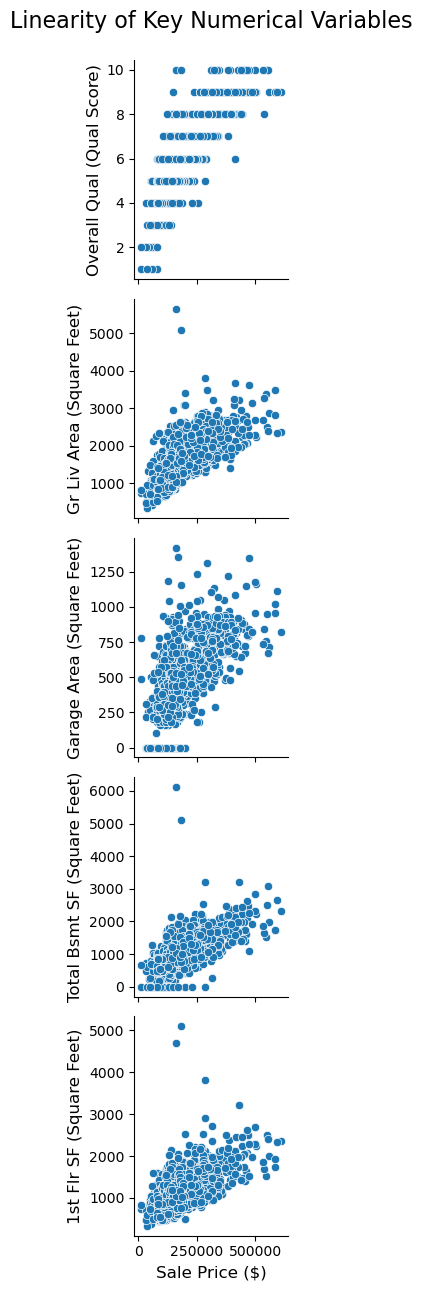

In [437]:
#Exploring linearity

pairplot = sns.pairplot(df, y_vars=['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF'], x_vars=['SalePrice'])

# Dictionary of units for each variable
units_dict = {
    'Overall Qual': 'Qual Score',
    'Gr Liv Area': 'Square Feet',
    'Garage Area': 'Square Feet',
    'Total Bsmt SF': 'Square Feet',
    '1st Flr SF': 'Square Feet',
}

# Add units to the Y-axis labels
for ax, variable in zip(pairplot.axes.flat, ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF']):
    ax.set_ylabel(f"{variable} ({units_dict[variable]})", fontsize=12)
    ax.set_xlabel(f"SalePrice (Dollars)", fontsize=12)

# Add X-axis label
pairplot.set(xlabel="Sale Price ($)")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  # You can adjust the spacing as needed
plt.title("Linearity of Key Numerical Variables", y=5.5, verticalalignment='center', fontsize=16)

pairplot.fig.savefig('../images/Linearity_Variables_Pairplot.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

plt.close()

In [438]:
# pres_pairplot = sns.pairplot(df, y_vars=['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF'], x_vars=['SalePrice'])

# # Dictionary of units for each variable
# units_dict = {
#     'Gr Liv Area': 'Square Feet',
#     'Garage Area': 'Square Feet',
#     'Total Bsmt SF': 'Square Feet',
#     '1st Flr SF': 'Square Feet',
# }

# # Add units to the Y-axis labels
# for ax, variable in zip(pres_pairplot.axes.flat, ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF']):
#     ax.set_ylabel(f"{variable} ({units_dict[variable]})", fontsize=12)
#     ax.set_xlabel(f"SalePrice (Dollars)", fontsize=12)

# # Add X-axis label
# pres_pairplot.set(xlabel="Sale Price ($)")
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.5)  # You can adjust the spacing as needed
# plt.title("Linearity of Key Numerical Variables", y=4.5, verticalalignment='center', fontsize=16)

# pres_pairplot.fig.savefig('../images/Pres_Linearity_Variables_Pairplot.png', bbox_inches='tight', dpi=300)

# # Show the plot
# plt.show()

# plt.close()

In [439]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour',
       ...
       'Total Bsmt SF Times 1st Flr SF', 'Gr Liv Area Times Garage Area',
       '1st Flr SF Times 2nd Flr SF', 'Wood Deck SF Times Open Porch SF',
       'Quality Factor', 'Not Kitchen Qual_TA', 'Not Kitchen Qual_Fa',
       'Not Heating QC_TA', 'Not Heating QC_Gd', 'Not Neighborhood_OldTown'],
      dtype='object', length=149)

In [440]:
# # Heatmap for the presentation
# selected_columns = ['Year Remod/Add', 'Kitchen Qual_Ex', 'Year Built', '1st Flr SF', 'Total Bsmt SF',
#                      'Exter Qual', 'Garage Cars', 'Garage Area', 'Gr Liv Area', 'Quality Factor',
#                      'Gr Liv Area Times Garage Area', 'Overall Qual', 'SalePrice']

# selected_df = df[selected_columns]

# # Calculate the correlation matrix
# correlation_matrix = selected_df.corr()

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# presentation_heatmap = sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

In [441]:
# presentation_heatmap.figure.savefig('../images/presentation_heatmap.png', bbox_inches='tight', dpi=300)

In [442]:
categorical_columns_new = ['Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
                       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
                       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
                       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
                       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
                       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
                       'Sale Type']

# Create dummy variables
df_dummies_new = pd.get_dummies(df[categorical_columns_new], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, df_dummies_new], axis=1)

# Drop the original categorical columns
df = df.drop(categorical_columns_new, axis=1)

In [443]:
# Create dummy variables
df_dummies_new_kag = pd.get_dummies(kaggle_data[categorical_columns_new], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
kaggle_data = pd.concat([kaggle_data, df_dummies_new_kag], axis=1)

# Drop the original categorical columns
kaggle_data = kaggle_data.drop(categorical_columns_new, axis=1)

In [444]:
dummy_variable_names = df_dummies_new_kag.columns.tolist()

## Training and Modeling Section With `Train.csv` file imported as `df`

In [445]:
# After 2000 is our only dummy variable
# Exter Qual is our only feature
#'Gr Liv Area Times Garage Area' is an area booster
# 'Total Bsmt SF Times 1st Flr SF' performed poorly and was deducted
#Trying Dummies 01/13/2023
#First Kitchen Quality 
#Second Heating Quality
#Third Electrical Fuses - Do Not Use
#Now try the externals: 
# take out 'Lot Frontage'
# Now try the inverses

features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars','Total Bsmt SF',
            '1st Flr SF','Year Built','Year Remod/Add','Full Bath','Garage Yr Blt','TotRms AbvGrd',
            'Mas Vnr Area','Fireplaces','BsmtFin SF 1','Wood Deck SF','Open Porch SF',
            'After 2000','Exter Qual','Overall Qual','Gr Liv Area Times Garage Area',
            'Kitchen Qual_Ex','Kitchen Qual_Fa','Kitchen Qual_Gd','Kitchen Qual_TA','Total Bsmt SF Times 1st Flr SF',
            'Heating QC_Ex','Heating QC_Fa','Heating QC_Gd','Heating QC_TA','1st Flr SF Times 2nd Flr SF',
            'Neighborhood_NridgHt','Neighborhood_Timber','Bsmt Full Bath','Neighborhood_StoneBr',
            'Neighborhood_Somerst','Neighborhood_NoRidge',
            # 'Functional_Maj1','Functional_Maj2','Functional_Min1','Functional_Min2','Functional_Mod','Functional_Typ'
            'Not Kitchen Qual_TA','Not Heating QC_TA','Not Neighborhood_OldTown'
           ]

X = df[features]
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    train_size=0.90)

In [446]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)

X_test = ss.transform(X_test)

In [447]:
df[features].isna().sum()

Overall Qual                      0
Gr Liv Area                       0
Garage Area                       0
Garage Cars                       0
Total Bsmt SF                     0
1st Flr SF                        0
Year Built                        0
Year Remod/Add                    0
Full Bath                         0
Garage Yr Blt                     0
TotRms AbvGrd                     0
Mas Vnr Area                      0
Fireplaces                        0
BsmtFin SF 1                      0
Wood Deck SF                      0
Open Porch SF                     0
After 2000                        0
Exter Qual                        0
Overall Qual                      0
Gr Liv Area Times Garage Area     0
Kitchen Qual_Ex                   0
Kitchen Qual_Fa                   0
Kitchen Qual_Fa                   0
Kitchen Qual_Gd                   0
Kitchen Qual_Gd                   0
Kitchen Qual_TA                   0
Kitchen Qual_TA                   0
Total Bsmt SF Times 1st Flr 

In [448]:
# Instantiate a linear regression model.
linmod = LinearRegression()

# Fit our linear regression model to the training data.
linmod.fit(X_train,y_train)

LinearRegression()

In [449]:
lasso = Lasso()

ridge = Ridge()

In [450]:
lasso.fit(X_train,y_train)

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+11, tolerance: 1.166e+09
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [451]:
ridge.fit(X_train,y_train)

Ridge()

In [452]:
# Print out intercept and coefficients - linear
print(f'Intercept: {linmod.intercept_}')
print(f'Coefficient: {linmod.coef_}')

Intercept: 182065.6671853289
Coefficient: [ 8.67561084e+13  1.31296484e+04 -9.00709082e+03  1.81034473e+03
  2.73283457e+04  1.30028164e+04  3.07591016e+03  4.93566504e+03
 -6.49969238e+02 -8.25794922e+02  2.14492432e+03  4.05927539e+03
  5.47805908e+03  8.25553711e+03  2.04600342e+03  7.22168457e+02
  2.35948096e+03  2.57918066e+03 -8.67561084e+13  2.57587061e+04
  1.24744593e+16  2.99162761e+15  4.27508575e+15  1.13814458e+16
  1.16374044e+16  8.98313171e+15  8.13076810e+15 -4.19980547e+04
  2.35488965e+03 -1.90034287e+14  1.90034287e+14  3.44539978e+14
 -3.44539978e+14 -4.36045993e+13  4.52374604e+14 -5.27330859e+03
 -2.60373832e+14  2.60373832e+14 -2.30056146e+14  2.30056146e+14
  1.35067847e+03 -3.56907502e+14  3.56907502e+14  1.19740079e+15
 -1.19740079e+15 -8.63120003e+12  8.63120003e+12 -6.43842386e+15
  4.08770005e+14  1.86243042e+03]


In [453]:
# Print out intercept and coefficients - lasso
print(f'Intercept: {lasso.intercept_}')
print(f'Coefficient: {lasso.coef_}')

Intercept: 182064.33983739838
Coefficient: [ 5.36110483e+04  1.31216453e+04 -8.94193722e+03  1.79411150e+03
  2.73128736e+04  1.30234281e+04  3.07080650e+03  4.94235447e+03
 -6.46236598e+02 -8.14150107e+02  2.14159993e+03  4.06452038e+03
  5.47986440e+03  8.25030632e+03  2.04524955e+03  7.24375766e+02
  2.35687386e+03  2.56707444e+03 -3.71404013e+04  2.56682254e+04
  9.64275163e+03 -5.66663865e+02 -0.00000000e+00 -3.36844397e+03
 -3.44094134e-10  3.00708003e+02  9.63719318e-14 -4.19639308e+04
  1.94125306e+03 -3.56089998e+02 -7.98087763e-13  4.79480546e+02
  3.43340412e-13 -3.04845572e+03 -0.00000000e+00 -5.23149371e+03
  6.67456488e+03  3.99148214e-09  1.64527758e+03  5.68893619e-10
  1.35206138e+03  6.64523092e+03  7.47753639e-10  1.73323415e+03
  0.00000000e+00  4.59150477e+03  2.55980710e-09  4.30494516e+03
 -1.50653148e+03  1.86271831e+03]


In [454]:
# Print out intercept and coefficients - ridge
print(f'Intercept: {ridge.intercept_}')
print(f'Coefficient: {ridge.coef_}')

Intercept: 182064.33983739838
Coefficient: [  8237.63492029  13076.10235099  -8452.34351326   1774.64921353
  26958.13844499  13076.73233703   3075.06393785   4920.76346725
   -623.04786268   -817.65242515   2158.19946675   4071.21919689
   5491.35240614   8219.33879729   2044.44077937    729.26152736
   2350.22734065   2577.55707806   8237.6349203   24895.96427926
   8704.82266406   -560.80109838   -560.80109838  -2559.98825342
  -2559.98825342  -1935.46884909  -1935.46884909 -41409.86853693
   2286.05390073   -119.8578836    -119.8578836     361.94049168
    361.94049169   -413.10167397   -413.10167397  -4935.36869745
   3352.3742235    3352.3742235     826.5906748     826.5906748
   1380.58358671   3328.80168438   3328.80168438    868.81722332
    868.81722332   2307.4961275    2307.4961275    1935.46884913
    413.10167397   1869.87359971]


In [455]:
#predict
prediction_lin = linmod.predict(X_test)

#actual
actual = y_test

train_score_lin = linmod.score(X_train, y_train)
test_score_lin = linmod.score(X_test, y_test)

print("The train score for lin model is {}".format(train_score_lin))
print("The test score for lin model is {}".format(test_score_lin))

The train score for lin model is 0.8732175985014468
The test score for lin model is 0.8967047486901939


In [456]:
# And same for the other models 
#predict
prediction_lasso = lasso.predict(X_test)

#actual
actual = y_test

train_score_lasso = lasso.score(X_train, y_train)
test_score_lasso = lasso.score(X_test, y_test)

print("The train score for lasso model is {}".format(train_score_lasso))
print("The test score for lasso model is {}".format(test_score_lasso))

The train score for lasso model is 0.8732174963791982
The test score for lasso model is 0.8967215151800543


In [457]:
#predict
prediction_ridge = ridge.predict(X_test)

#actual
actual = y_test

train_score_ridge = ridge.score(X_train, y_train)
test_score_ridge = ridge.score(X_test, y_test)

print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))

The train score for ridge model is 0.8732124073865104
The test score for ridge model is 0.8967090015852264


# Other Fits

A look at non-linearity, polynomial features for a better characteristic equation. 

In [458]:
poly = PolynomialFeatures(degree=2,include_bias=False)

In [459]:
X_train = poly.fit_transform(X_train)

X_test = poly.transform(X_test)

Cubed order units $\text{m}^3$ term present in characteristic equation. 

In [460]:
linmod.fit(X_train,y_train)

LinearRegression()

In [461]:
lasso_model = LassoCV(max_iter=10000)

In [462]:
lasso_model.fit(X_train,y_train)

LassoCV(max_iter=10000)

In [463]:
r_alphas = np.logspace(0,5,100)

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, cv = 5, scoring='r2')
# Fit model using best ridge alpha!
ridge_model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [464]:
# # Set up a list of Lasso alphas to check.
# l_alphas = np.logspace(-3, 0 , 100)
# # Cross-validate over our list of Lasso alphas.
# lasso_model = LassoCV(alphas=l_alphas, cv = 5, max_iter=50000)
# # Fit model using best ridge alpha!
# lasso_model.fit(X_train, y_train)

In [465]:
# r_alphas = np.logspace(0,5,100)

# # Cross-validate over our list of ridge alphas.
# ridge_model = RidgeCV(alphas=r_alphas, cv = 5, scoring='r2')
# # Fit model using best ridge alpha!
# ridge_model.fit(X_train, y_train)

In [466]:
#predict
prediction_lin = linmod.predict(X_test)

#actual
actual = y_test

train_score_lin = linmod.score(X_train, y_train)
test_score_lin = linmod.score(X_test, y_test)

print("The train score for lin model is {}".format(train_score_lin))
print("The test score for lin model is {}".format(test_score_lin))

The train score for lin model is 0.9605953743630793
The test score for lin model is -4.0637034177094536e+20


In [467]:
# And same for the other models 
#predict
prediction_lasso = lasso_model.predict(X_test)

#actual
actual = y_test

train_score_lasso = lasso_model.score(X_train, y_train)
test_score_lasso = lasso_model.score(X_test, y_test)

print("The train score for lasso model is {}".format(train_score_lasso))
print("The test score for lasso model is {}".format(test_score_lasso))
print(f"{round(((train_score_lasso - test_score_lasso)*100),2)}% difference")

The train score for lasso model is 0.9282990724185396
The test score for lasso model is 0.9276156429787737
0.07% difference


In [468]:
#predict
prediction_ridge = ridge_model.predict(X_test)

#actual
actual = y_test

train_score_ridge = ridge_model.score(X_train, y_train)
test_score_ridge = ridge_model.score(X_test, y_test)

print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))
print(f"{round(((train_score_ridge - test_score_ridge)*100),2)}% difference")

The train score for ridge model is 0.936613489173677
The test score for ridge model is 0.9236854385129851
1.29% difference


# Error Metrics Section

In [469]:
print(f"MAE Ridge | {mean_absolute_error(y_test, prediction_ridge)}")

MAE Ridge | 15710.798159979275


In [470]:
print(f"MAE Lasso | {mean_absolute_error(y_test, prediction_lasso)}")

MAE Lasso | 14448.120785322442


In [471]:
print(f"MAE Linear | {mean_absolute_error(y_test, prediction_lin)}")

MAE Linear | 107764930840361.84


In [472]:
# RSS Ridge
sum((y_test - prediction_ridge)**2)

92549645269.69948

In [473]:
# RSS Lasso
sum((y_test - prediction_lasso)**2)

87783333021.30875

In [474]:
# RSS Linear
sum((y_test - prediction_lin)**2)

4.928211634345418e+32

In [475]:
# MSE Ridge
mean_squared_error(y_test, prediction_ridge)

449270122.66844416

In [476]:
# MSE Lasso
mean_squared_error(y_test, prediction_lasso)

426132684.5694604

In [477]:
# MSE Linear
mean_squared_error(y_test, prediction_lin)

2.392335744827873e+30

In [478]:
# Root Mean Squared Error Ridge
print(f"RMSE Ridge | {np.sqrt(mean_squared_error(y_test, prediction_ridge))}")

RMSE Ridge | 21195.99308049623


In [479]:
# Root Mean Squared Error Lasso
print(f"RMSE Lasso | {np.sqrt(mean_squared_error(y_test, prediction_lasso))}")

RMSE Lasso | 20642.981484501226


In [480]:
# Root Mean Squared Error Linear
print(f"RMSE Linear | {np.sqrt(mean_squared_error(y_test, prediction_lin))}")

RMSE Linear | 1546717732757943.5


### Export

Please note we have a dataframe read for our X_test and y_test data and for the proceeding section we have a numpy array from our kaggle_data (holdout test set) that we convert to a dataframe use for our ridge model and export as a csv to submit to Kaggle. 

Indices read-in via features list which we have via indexing methods. 

kaggle_data is short a column, this is the `sales price` variable and our objective is to predict these values. 

In [481]:
df.shape

(2051, 306)

In [482]:
kaggle_data.shape

(878, 288)

In [483]:
X_train.shape

(1845, 1325)

In [484]:
X_test.shape

(206, 1325)

In [485]:
kaggle_data[features] = ss.transform(kaggle_data[features])

In [493]:
kaggle_data[features].columns

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt', 'TotRms AbvGrd', 'Mas Vnr Area',
       'Fireplaces', 'BsmtFin SF 1', 'Wood Deck SF', 'Open Porch SF',
       'After 2000', 'Exter Qual', 'Overall Qual',
       'Gr Liv Area Times Garage Area', 'Kitchen Qual_Ex', 'Kitchen Qual_Fa',
       'Kitchen Qual_Fa', 'Kitchen Qual_Gd', 'Kitchen Qual_Gd',
       'Kitchen Qual_TA', 'Kitchen Qual_TA', 'Total Bsmt SF Times 1st Flr SF',
       'Heating QC_Ex', 'Heating QC_Fa', 'Heating QC_Fa', 'Heating QC_Gd',
       'Heating QC_Gd', 'Heating QC_TA', 'Heating QC_TA',
       '1st Flr SF Times 2nd Flr SF', 'Neighborhood_NridgHt',
       'Neighborhood_NridgHt', 'Neighborhood_Timber', 'Neighborhood_Timber',
       'Bsmt Full Bath', 'Neighborhood_StoneBr', 'Neighborhood_StoneBr',
       'Neighborhood_Somerst', 'Neighborhood_Somerst', 'Neighborhood_NoRidge',
       'Neighborhood_NoRid

In [487]:
kaggle_data[features].shape

(878, 50)

In [488]:
# Ignore following warning we have verified there are no conflicts

In [489]:
# Transform test kaggle data
X_transformed = poly.transform(kaggle_data[features])  # X is your input data

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


In [490]:
X_transformed.shape

(878, 1325)

In [491]:
kaggle_data.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour',
       ...
       'Misc Feature_Shed', 'Sale Type_CWD', 'Sale Type_Con',
       'Sale Type_ConLD', 'Sale Type_ConLI', 'Sale Type_ConLw',
       'Sale Type_New', 'Sale Type_Oth', 'Sale Type_VWD', 'Sale Type_WD '],
      dtype='object', length=288)

In [494]:
# new_frame_to_pred = pd.DataFrame(X_transformed, columns=poly.get_feature_names_out(features))
# new_frame_to_pred;

# Only Run the Following Cell When You Are Ready to Export!

Again, we ignore the warning as it turns out the problem has been 
resolved via indexing methods to confirm columns have been read in correctly. 

In [495]:
# #Only uncomment to create file - currently needs renaming
# submission = pd.DataFrame({'id': kaggle_data['Id']})
# submission['SalePrice'] = lasso_model.predict(new_frame_to_pred)

# submission.to_csv('../datasets/mean_submission_lasso_model_no0fill_median_1115.csv', index=False)